In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
import dgl
from dgl.data import DGLDataset
import torch
import os

edges_fMRI = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
# edges_dMRI_fused = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
# edges_dMRI_ses1 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses1.csv')
# edges_dMRI_ses2 = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_ses2.csv')
properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')

edges_fMRI.head()

properties.head()

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_weighted_edges_0.8.csv')
        properties = pd.read_csv('./BNU1_fMRI/fMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['src'].to_numpy()
            dst = edges_of_id['dst'].to_numpy()
            weight = edges_of_id['weight'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            weight = torch.FloatTensor(weight)
            g.edata['weight'] = weight
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)

Using backend: pytorch


Graph(num_nodes=70, num_edges=24,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}) tensor(1)


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import re
%matplotlib inline

graph_idx = 0
pos_idx = []
neg_idx = []
f = csv.reader(open('./BNU1_fMRI/BNU1_phenotypic_data.csv','r')) 
for j, row in enumerate(f):
    if j != 0 and j % 2 ==1:
        label = row[3]
        filter(str.isdigit, label)
        if int(label)-1 == 1:
            pos_idx.append(graph_idx)
        else:
            neg_idx.append(graph_idx)
        graph_idx += 1

edge_list_2_downsampling = []
edge_list_2_property = [] 
pos_adj_list = []
neg_adj_list = []
adj_list = []
labels = []
length = 25920 - 25864 + 1
for i in range(length):
    G00 = nx.read_gpickle("./BNU1_fMRI/sub-00%s_ses-1_bold_desikan_res-2x2x2_measure-correlation.gpickle"%(int(i+25864)))
    edge_list_2 = []
    edge = G00.adj
    for src in edge:
        for dst in edge[src]:
            edge_list_2.append([src, dst, edge[src][dst]['weight']])
    for edge in edge_list_2:
        if edge[0] == edge[1]:
            continue
        elif edge[2] <= 0.8:
            edge_list_2_downsampling.append([edge[0]-1, edge[1]-1, 0])
        else:
            edge_list_2_downsampling.append([edge[0]-1, edge[1]-1, edge[2]])
    G2 = nx.Graph()
    G2.add_weighted_edges_from(edge_list_2_downsampling)
    A2 = nx.to_numpy_array(G2)
    adj_list.append(A2)
    if i in pos_idx:
        labels.append('male')
        pos_adj_list.append(A2)
#         np.stack((pos_adj_list, A2),axis=0)
    else:
        labels.append('female')
        neg_adj_list.append(A2)

In [2]:
# Embed mice graphs
# Single graph embedding
from graspologic.embed import node2vec_embed, AdjacencySpectralEmbed, LaplacianSpectralEmbed
# Multiple graph embedding
from graspologic.embed import OmnibusEmbed, MultipleASE, mug2vec
from graspologic.plot import pairplot

# Jointly embed graphs using omnibus embedding
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(adj_list)
print(omni_embedding.shape)

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\graspologic\embed\omni.py:258: UserWarning: Input graphs are not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.multigraph_lcc_union``.
  warnings.warn(msg, UserWarning)


(57, 70, 7)


PolynomialFeatures(degree=6)


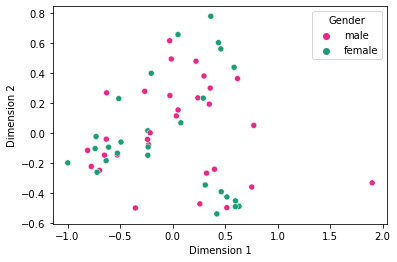

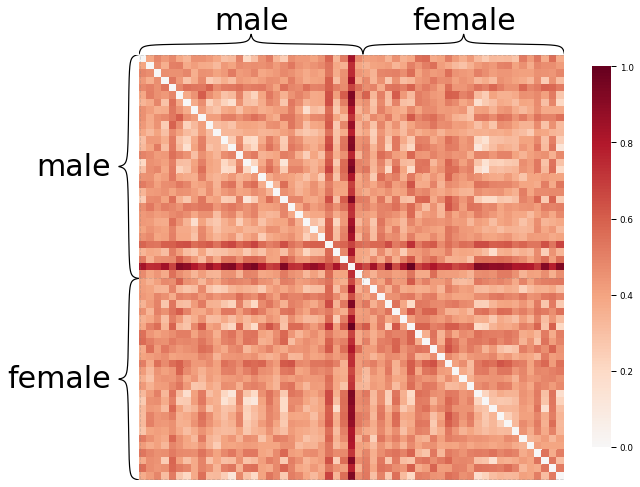

In [6]:
from graspologic.embed import ClassicalMDS
from graspologic.plot import heatmap
from sklearn.preprocessing import PolynomialFeatures

# Further reduce embedding dimensionality using cMDS
cmds = ClassicalMDS(2)
cmds_embedding_ = cmds.fit_transform(omni_embedding)
cmds_embedding = pd.DataFrame(cmds_embedding_, columns=["Dimension 1", "Dimension 2"])
cmds_embedding["Gender"] = labels
degree_nodal_covariates = PolynomialFeatures(degree=6)
print(degree_nodal_covariates)

# Embedding visualization
sns.scatterplot(
    x="Dimension 1",
    y="Dimension 2",
    hue="Gender",
    data=cmds_embedding,
    palette=["#e7298a", "#1b9e77"],
)
plt.show()

# Find the dissimilarity between subjects' connectomes using the cMDS embedding
dis = cmds.dissimilarity_matrix_
scaled_dissimilarity = dis / np.max(dis)

heatmap(scaled_dissimilarity,
        context="paper",
        inner_hier_labels=labels,)
plt.show()

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5263157894736842


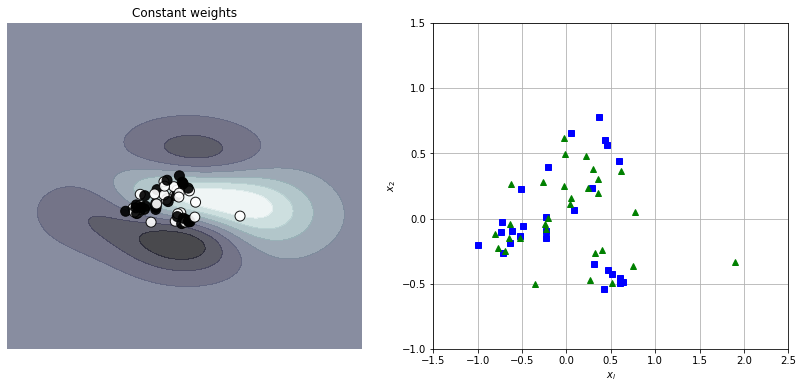

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
X = cmds_embedding_.reshape(omni_embedding.shape[0], -1)
one_hot = LabelBinarizer()
labels = np.array(labels)
y = one_hot.fit_transform(labels)

def plot_dataset(X, y, axes):
    plt.plot( X[:,0][y==0], X[:,1][y==0], "bs" )
    plt.plot( X[:,0][y==1], X[:,1][y==1], "g^" )
    plt.axis( axes )
    plt.grid( True, which="both" )
    plt.xlabel(r"$x_l$")
    plt.ylabel(r"$x_2$")

def plot_predict(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid( x0s, x1s )
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict( X )
    y_decision = clf.decision_function( X )
    y_pred_ = np.array(y_pred).reshape[-1, 1]
    plt.contour( x0, x1, y_pred_, cmap=plt.cm.winter, alpha=0.5 )
    plt.contour( x0, x1, y_decision, cmap=plt.cm.winter, alpha=0.2 )

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500)) # 网格矩阵

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]) #
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone) 
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black') 

    axis.axis('off')   
    axis.set_title(title)    
    
from sklearn.svm import SVC
clf = Pipeline([ ('scaler', StandardScaler()), 
                 ('svm_clf', SVC(kernel="rbf", gamma=0.1, C=0.001))
               ])
clf.fit(X, y)
pred = clf.predict(X)
decision=clf.decision_function(X)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(clf, sample_weight_constant, axes[0],
                       "Constant weights")
y_ = y.flatten()
plot_dataset( X, y_, [-1.5, 2.5, -1, 1.5] )
print(accuracy_score(pred, y))

C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\isjak\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7368421052631579


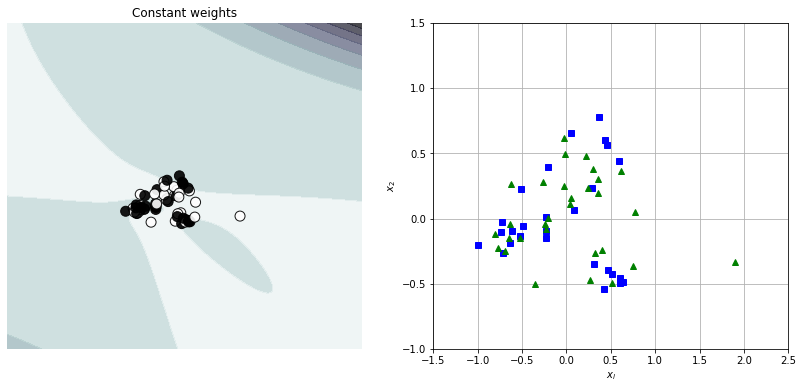

In [74]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
clf = Pipeline([ ('features', degree_nodal_covariates),
                 ('scaler', StandardScaler()), 
                 ('svm_clf', LinearSVC(C=10, loss="hinge", random_state=42))
               ])
clf.fit(X, y)
pred = clf.predict(X)
decision=clf.decision_function(X)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sample_weight_constant = np.ones(len(X))
plot_decision_function(clf, sample_weight_constant, axes[0],
                       "Constant weights")
y_ = y.flatten()
plot_dataset( X, y_, [-1.5, 2.5, -1, 1.5] )
# print(pred, labels)
print(accuracy_score(pred, y))